# Topic:        Challenge Set 1  
## Subject:      Explore MTA turnstile data
## Date:         01/15/2018
## Name:         Mauro Mario Gentile
## Worked with: Wendy Sanchez-Vaynshteyn

Note: we preferred to submit the challenges using dictionaries since we felt it was more challenging and to build skills on it

In [1]:
import pandas as pd
import glob
import csv
from collections import defaultdict
from  dateutil import parser

In [2]:
test_size=0.30 
random_state=4444

## Challenge 1
    

In [3]:
def load_week(date):#in yrmmdd format 6 digits in total    
    data_dict=defaultdict(list) 
    file_n1='data/turnstile_'+date+'.txt'
    with open(file_n1) as csvfile:
        reader = csv.reader(csvfile)
        column_names=next(reader) #extract column names
        column_names=list(map(lambda x: x.strip(), column_names)) #strip columns names
        for row in reader:
            data_dict[tuple(k for k in row[0:4])].append([r.strip() for r  in row[4:]])
    return(data_dict, column_names)

In [4]:
data_dict, column_names=load_week("150627")

In [5]:
#As a check, output the first 10 lines of a sample from the dict 
sample_key=list(data_dict.keys())[0]
print("STATION:",sample_key)
print("DATA:",data_dict[('A002', 'R051', '02-00-00', 'LEXINGTON AVE')][:10])


STATION: ('A002', 'R051', '02-00-00', 'LEXINGTON AVE')
DATA: [['NQR456', 'BMT', '06/20/2015', '00:00:00', 'REGULAR', '0005192500', '0001756572'], ['NQR456', 'BMT', '06/20/2015', '04:00:00', 'REGULAR', '0005192550', '0001756580'], ['NQR456', 'BMT', '06/20/2015', '08:00:00', 'REGULAR', '0005192568', '0001756609'], ['NQR456', 'BMT', '06/20/2015', '12:00:00', 'REGULAR', '0005192670', '0001756706'], ['NQR456', 'BMT', '06/20/2015', '16:00:00', 'REGULAR', '0005192886', '0001756776'], ['NQR456', 'BMT', '06/20/2015', '20:00:00', 'REGULAR', '0005193250', '0001756837'], ['NQR456', 'BMT', '06/21/2015', '00:00:00', 'REGULAR', '0005193409', '0001756875'], ['NQR456', 'BMT', '06/21/2015', '04:00:00', 'REGULAR', '0005193435', '0001756882'], ['NQR456', 'BMT', '06/21/2015', '08:00:00', 'REGULAR', '0005193461', '0001756900'], ['NQR456', 'BMT', '06/21/2015', '12:00:00', 'REGULAR', '0005193533', '0001756954']]


# Challenge 2

In [6]:
def entries(data_dict):
    Date_column_number=column_names.index("DATE")-4
    Time_column_number=column_names.index("TIME")-4
    Entries_column_number=column_names.index("ENTRIES")-4 # afer having used the first 4 fields as index
    return({key:[[parser.parse(v[Date_column_number] + " "+v[Time_column_number], dayfirst=False,yearfirst=False )
             ,int(v[Entries_column_number])] for v in value] for key, value in data_dict.items()})

entr=entries(data_dict)

In [7]:
#check
sample_key=list(entr.keys())[42]
print("STATION:",sample_key)
print("DATA:",entr[sample_key][:10])

STATION: ('A013', 'R081', '01-03-01', '49 ST-7 AVE')
DATA: [[datetime.datetime(2015, 6, 20, 0, 0), 3914939], [datetime.datetime(2015, 6, 20, 4, 0), 3915143], [datetime.datetime(2015, 6, 20, 8, 0), 3915188], [datetime.datetime(2015, 6, 20, 12, 0), 3915334], [datetime.datetime(2015, 6, 20, 16, 0), 3915658], [datetime.datetime(2015, 6, 20, 20, 0), 3916121], [datetime.datetime(2015, 6, 21, 0, 0), 3916598], [datetime.datetime(2015, 6, 21, 4, 0), 3916791], [datetime.datetime(2015, 6, 21, 8, 0), 3916826], [datetime.datetime(2015, 6, 21, 12, 0), 3916945]]


# Challenge 3

In [8]:
def delta_entries(entries):
    entries={key:sorted(value) for key,value in entries.items()}
    return({key: [[value[i][0], value[i+1][1] - value[i][1],
                                     value[i+1][0] - value[i][0]]# date, delta count, delta time
                                    for i in range(len(value) - 1)]
                        for key, value in entries.items()} )
delta_entr=delta_entries(entr)

In [9]:
#only counts between 1 and 5000
def cut_negative_and_highest_delta(delta_entries, lower_cutoff,upper_cutoff):
    return {key: [v for v in value if v[1]>lower_cutoff and v[1]<upper_cutoff] for key,value in delta_entries.items()}


delta_entr=cut_negative_and_highest_delta(delta_entr, 0,5000)

In [10]:
def counts_by_day(delta_entries):
    by_day={}
    for key, value in delta_entries.items():
        counts={}
        for v in value: 
            counts[v[0].date()]= counts.get(v[0].date(),0)+v[1]
        by_day[key]=counts
    return(by_day)

by_day=counts_by_day(delta_entr)

In [11]:
by_day['N135', 'R385', '01-03-00', 'ROCKAWAY BLVD']

{datetime.date(2015, 6, 20): 271,
 datetime.date(2015, 6, 21): 201,
 datetime.date(2015, 6, 22): 561,
 datetime.date(2015, 6, 23): 543,
 datetime.date(2015, 6, 24): 555,
 datetime.date(2015, 6, 25): 556,
 datetime.date(2015, 6, 26): 543}

# Challenge 4

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))

def plot_turnstile_daily_entries(turnstile,by_day):
    by_day_as_list={k: [list(v.keys()), list(v.values())] for k, v in by_day.items()}
    dates, counts= by_day_as_list[turnstile]
    plt.figure(figsize=(10,3))
    plt.title("week flow at "+turnstile[0]+" "+turnstile[1]+" "+turnstile[2]+" "+turnstile[3] )
    plt.xlabel("days")
    plt.ylabel("Flow")
    
    plt.plot(dates,counts)

    

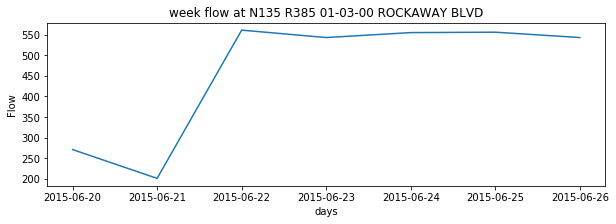

In [13]:
plot_turnstile_daily_entries(('N135', 'R385', '01-03-00', 'ROCKAWAY BLVD'),by_day)

# Challenge 5

In [14]:
def counts_by_day_by_ca(by_day):
    by_day_by_ca={}
    for key, value in by_day.items():
        new_key=tuple([key[0],key[1],key[3]])
        if not(new_key in by_day_by_ca):
            by_day_by_ca[new_key]={}
        for v in value:        
            by_day_by_ca[new_key][v]= by_day_by_ca[new_key].get(v,0)+value[v]
    return(by_day_by_ca)
by_day_by_ca=counts_by_day_by_ca(by_day)


# Challenge 6

In [15]:
def counts_by_day_by_station(by_day_by_ca):
    by_day_by_station={}
    for key, value in by_day_by_ca.items():
        new_key=tuple([key[2]])
        if not(new_key in by_day_by_station):
            by_day_by_station[new_key]={}
        for v in value:        
            by_day_by_station[new_key][v]= by_day_by_station[new_key].get(v,0)+value[v] 
    return(by_day_by_station)

by_day_by_station=counts_by_day_by_station(by_day_by_ca)

# Challenge 7

In [16]:

def plot_station_daily_entries(Station,by_day_by_station):
    station_by_day_as_list={k: [list(v.keys()), list(v.values())] for k, v in by_day_by_station.items()}
    dates, counts= station_by_day_as_list[tuple([Station])]
    plt.figure(figsize=(10,3))
    plt.title("week flow at "+Station)
    plt.xlabel("days")
    plt.ylabel("Flow")
    plt.plot(dates,counts)


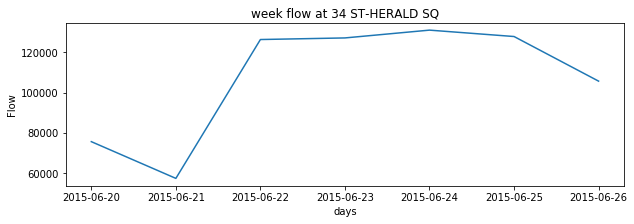

In [17]:
plot_station_daily_entries("34 ST-HERALD SQ",by_day_by_station)

# Challenge 8

In [18]:
def counts_by_weekday_name(Station,by_day_by_station):
    counts=defaultdict(str)
    for v in by_day_by_station[tuple([Station])]:
        counts[v.strftime("%A")]=by_day_by_station[tuple([Station])][v]
    return([counts["Monday"],counts["Tuesday"],counts["Wednesday"],counts["Thursday"],counts["Friday"],counts["Saturday"],counts["Sunday"]])    

In [19]:
counts_by_weekday_name("34 ST-HERALD SQ",by_day_by_station)

[126283, 127074, 130936, 127771, 105671, 75697, 57499]

In [20]:
lab1="180106"
lab2="171230"
lab3="171223"
lab4="171216"
week1, column_names=load_week("180106")
week2,_=load_week("171230")
week3,_=load_week("171223")
week4,_=load_week("171216")

In [21]:
entries1=entries(week1)
entries2=entries(week2)
entries3=entries(week3)
entries4=entries(week4)

In [22]:
delta_entr1=delta_entries(entries1)
delta_entr2=delta_entries(entries2)
delta_entr3=delta_entries(entries3)
delta_entr4=delta_entries(entries4)


In [23]:
lower_cutoff=0
upper_cutoff=5000

delta_entr1=cut_negative_and_highest_delta(delta_entr1, lower_cutoff,upper_cutoff)
delta_entr2=cut_negative_and_highest_delta(delta_entr2, lower_cutoff,upper_cutoff)
delta_entr3=cut_negative_and_highest_delta(delta_entr3, lower_cutoff,upper_cutoff)
delta_entr4=cut_negative_and_highest_delta(delta_entr4, lower_cutoff,upper_cutoff)

In [24]:
by_day1=counts_by_day(delta_entr1)
by_day2=counts_by_day(delta_entr2)
by_day3=counts_by_day(delta_entr3)
by_day4=counts_by_day(delta_entr4)

In [25]:
by_day_by_ca1=counts_by_day_by_ca(by_day1)
by_day_by_ca2=counts_by_day_by_ca(by_day2)
by_day_by_ca3=counts_by_day_by_ca(by_day3)
by_day_by_ca4=counts_by_day_by_ca(by_day4)

In [26]:
by_day_by_station1=counts_by_day_by_station(by_day_by_ca1)
by_day_by_station2=counts_by_day_by_station(by_day_by_ca2)
by_day_by_station3=counts_by_day_by_station(by_day_by_ca3)
by_day_by_station4=counts_by_day_by_station(by_day_by_ca4)

In [27]:
Station="34 ST-HERALD SQ"
count_by_w_day1=counts_by_weekday_name(Station,by_day_by_station1)
count_by_w_day2=counts_by_weekday_name(Station,by_day_by_station2)
count_by_w_day3=counts_by_weekday_name(Station,by_day_by_station3)
count_by_w_day4=counts_by_weekday_name(Station,by_day_by_station4)

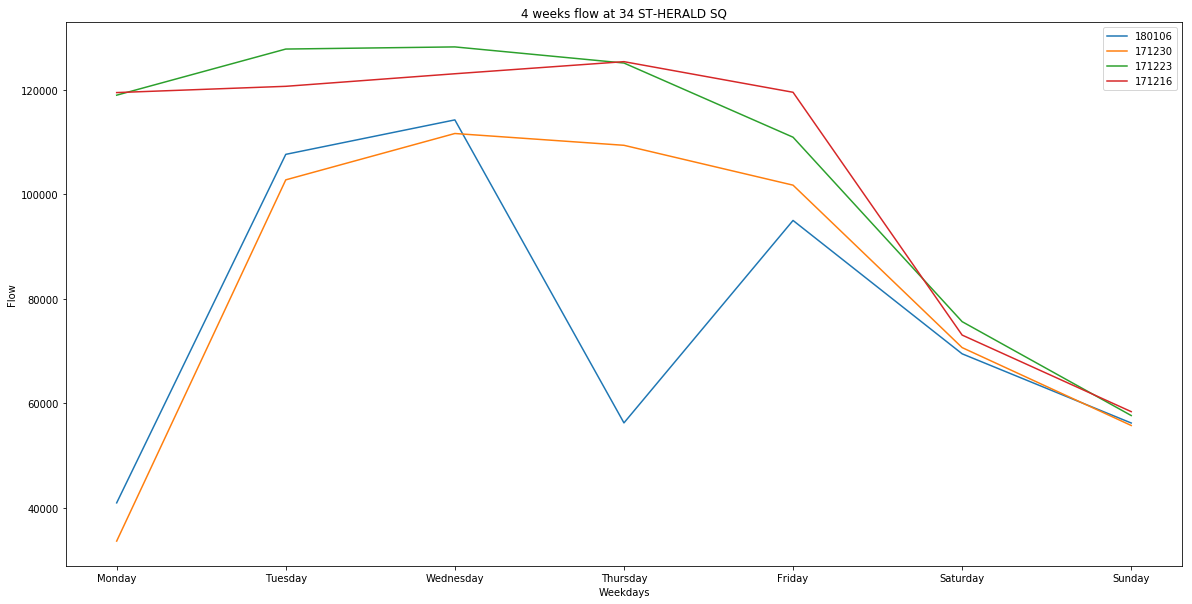

In [28]:
plt.figure(figsize=(20,10))
plt.plot(count_by_w_day1,label=lab1);
plt.plot(count_by_w_day2,label=lab2);
plt.plot(count_by_w_day3,label=lab3);
plt.plot(count_by_w_day4,label=lab4);
plt.title("4 weeks flow at "+Station)
plt.xlabel("Weekdays")
plt.ylabel("Flow")

labels=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
plt.xticks(range(0,7),labels);
plt.legend();

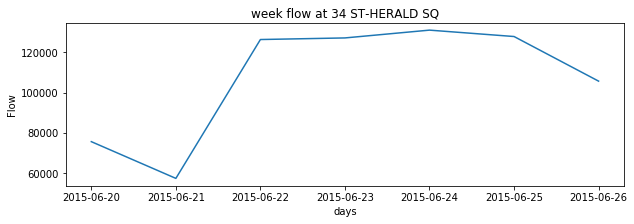

In [29]:
#The 2 below-the-average-mondays are January 1st and December 25th.
# In facts, as shown by the below graph, week 1, labelled "180106", is data UNTIL 
# Jan 6th which includes Jan 1st 2017, which was a Monday.

# Likewise, data labelled "171230" ends on Dec 30 and includes Xmas day which was a Monday.

plot_station_daily_entries("34 ST-HERALD SQ",by_day_by_station)

# Challenge 9

In [30]:
def merge_several_weeks_data_by_station(weeks):
    stations_dict=defaultdict(int)
    for week in weeks:
        for station in week:
            stations_dict[station]=stations_dict[station]+sum(list(week[station].values()))
    return(stations_dict)

In [31]:
merged=merge_several_weeks_data_by_station([by_day_by_station1,by_day_by_station2,by_day_by_station3,by_day_by_station4])

In [32]:
total_sorted_flow = [(k, merged[k]) for k in sorted(merged, key=merged.get, reverse=True)]

In [33]:
total_sorted_flow[:5]

[(('34 ST-PENN STA',), 3604323),
 (('GRD CNTRL-42 ST',), 3018551),
 (('34 ST-HERALD SQ',), 2609537),
 (('14 ST-UNION SQ',), 2308942),
 (('23 ST',), 2224658)]

# Challenge 10

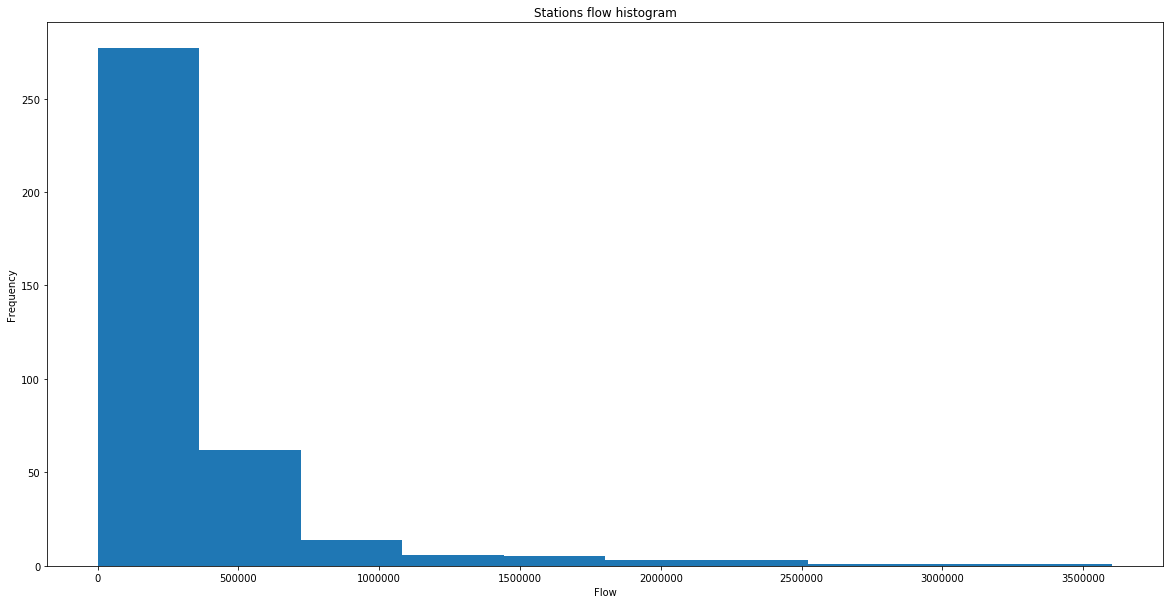

In [34]:
plt.figure(figsize=(20,10))
plt.title("Stations flow histogram")
plt.xlabel("Flow")
plt.ylabel("Frequency")
plt.hist(list(merged.values()));
plt.show()

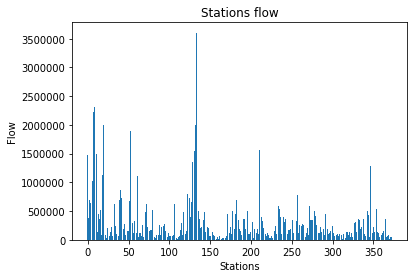

In [35]:
indices = range(len(list(merged.values())))
plt.bar(indices, list(merged.values()));
plt.title("Stations flow")
plt.xlabel("Stations")
plt.ylabel("Flow")
plt.show()